# WhatsApp Chat Analysis
This script analyzes your chat log with a friend to extract statistics and patterns, such as the number of messages sent by each person, average number of words written per hour of day or day of the week as well as the most used words etc.

I have tested this script using the chat history of me and my girlfriend. For privacy, I have removed the log file and all outputs displaying message contents.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import re
import collections

plt.style.use('ggplot')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load and preview chat log
We load the .txt file directly exported from WhatsApp containing the chat log. Using a regular expression, we extract each single message sent with sender information and time stamp. Additionally, we add a wordcount for each message to be used for statistical analyses.

In [34]:
# Defining names for loading and displaying
name1 = 'My name'
name2 = 'Her name'
nick1 = 'Me'
nick2 = 'Girlfriend'
chat = open('WhatsApp Chat with ' + name2 + '.txt', 'r', encoding="utf8")
chat_text = chat.read()
chat.close()

# Regular expression to read senders, messages, and times, matching the standard WhatsApp output format
regex = re.compile(r'^(\d{1,2}\/\d{1,2}\/\d{2},\s\d{2}:\d{2})\s-\s([^:]+):\s([\s\S]+?)(?=\n\d{1,2}/\d{1,2})', re.M)
transcript = regex.findall(chat_text)

# Load into DataFrame and format columns
df = pd.DataFrame(transcript, columns=['Datetime', 'Name', 'Message']).replace({name1:nick1, name2:nick2})


df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Wordcount'] = df['Message'].str.split().str.len()

# Preview last 10 messages
#df.tail(10)

,Datetime,Name,Message,Wordcount
0,2017-01-14 23:43:00,Me,🐵😘,1
1,2017-01-15 10:06:00,Me,Hello Dudiczku!,2
2,2017-01-15 10:07:00,Me,Good morning greetings from the road! 😘😘😘,7
3,2017-01-15 10:54:00,Me,How is your Sunday morning going?,6
4,2017-01-15 10:59:00,Girlfriend,Guten Morgen baybay! 😘,4


## Basic message and word count statistics
From the number of messages and word count, we acquire some basic statistics:
* Total number of messages sent
* Total number of words written
* Average number of words per text message

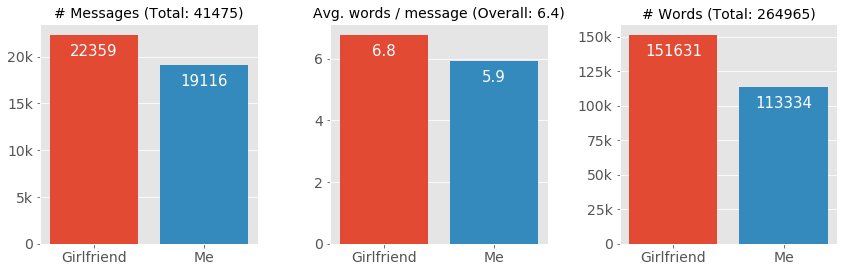

In [37]:
# Tick label formatter for displaying units of thousands
def thousands(x, pos):
    'The two args are the value and tick position'
    if x != 0:
        return '%1.0fk' % (x*1e-3)
    else:
        return '%1.0f' % x
formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,4))

# Messages
df_messages = df.groupby('Name').count().drop(['Datetime'], axis=1).rename(columns={'Message': 'Count'})
ax[0].bar(df_messages.index, df_messages['Count'], color=['C0', 'C1'])
ax[0].set_title('# Messages (Total: ' + str(df_messages['Count'].sum()) + ')')
ax[0].yaxis.set_major_formatter(formatter)
for i in ax[0].patches:
    ax[0].text(i.get_x() + 0.4, i.get_height() - max(df_messages['Count']) * 0.1, \
            str(i.get_height()), fontsize=15,
                color='w', horizontalalignment = 'center')
ax[0].grid(axis='x')

# Words per message
df_words_per_message = df.groupby('Name').mean()
ax[1].bar(df_words_per_message.index, df_words_per_message['Wordcount'], color=['C0', 'C1'])
ax[1].set_title('Avg. words / message (Overall: ' + str(round(df['Wordcount'].mean(), 1)) + ')')
for i in ax[1].patches:
    ax[1].text(i.get_x() + 0.4, i.get_height() - max(df_words_per_message['Wordcount']) * 0.1, \
            str(round(i.get_height(), 1)), fontsize=15,
                color='w', horizontalalignment = 'center')
ax[1].grid(axis='x')
plt.tight_layout()

# Words
df_words = df.groupby('Name').sum()
ax[2].bar(df_words.index, df_words['Wordcount'], color=['C0', 'C1'])
ax[2].set_title('# Words (Total: ' + str(df_words['Wordcount'].sum()) + ')')
ax[2].yaxis.set_major_formatter(formatter)
for i in ax[2].patches:
    ax[2].text(i.get_x() + 0.4, i.get_height() - max(df_words['Wordcount']) * 0.1, \
            str(i.get_height()), fontsize=15,
                color='w', horizontalalignment = 'center')
ax[2].grid(axis='x')

### Insights
- My girlfriend sends about 17% more messages than I do.
- Not only that, but she also tends to write more words in each message. 15% more, to be exact.
- This results in 34% more words written by her than by me.

## Hour-of-day statistic
Grouping the messages by the hour of day at which they are sent, gives us a neat statistic about messaging peak times throughout the day.

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3  4]


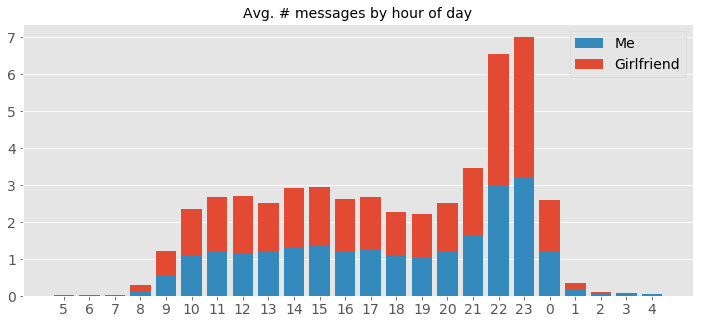

In [40]:
days_total = (df['Datetime'].iloc[-1] - df['Datetime'].iloc[0]).days
df_hours = df.groupby([df['Datetime'].dt.hour, 'Name'])\
             .count().unstack(fill_value=0).stack()\
             .drop(['Datetime'], axis=1)\
             .apply(lambda x: x/days_total)\
             .rename(columns={'Message': 'Count'})
df_hours.index.names = ['Hour', 'Name']

bars1 = df_hours.xs(nick1, level='Name')['Count']
bars2 = df_hours.xs(nick2, level='Name')['Count']

def shift(l, n):
    return np.append(l[n:], l[:n])

start_h = 5
h_order = shift(np.arange(0,24), start_h)

fig, ax = plt.subplots(figsize=(12,5))
ax.bar(np.arange(0,24), bars1.values[h_order], color='C1')
print(shift(np.arange(0,24), start_h))
ax.bar(np.arange(0,24), bars2.values[h_order], bottom=shift(bars1.values, start_h), color='C0')
ax.set_title('Avg. # messages by hour of day')
ax.legend([nick1, nick2])
ax.set_xticks(np.arange(0,24))
ax.set_xticklabels(h_order)
ax.grid(axis='x')

fig.savefig('whatsapp_preview.png')

### Insights
- The most obvious peak time for messaging with my girlfriend is between 10 pm to 11 pm for good-night wishes.
- Throughout the day, messages come at a fairly constant rate with a slight peak after lunch time.
- Not surprisingly, there is a very small number of messages at night hours. These, however, are almost exclusively sent by me.

## Day-of-week statistic
Similar to the hour-of-day statistic, we can analyze how the day of the week affects the number of messages sent between me and my girlfriend.

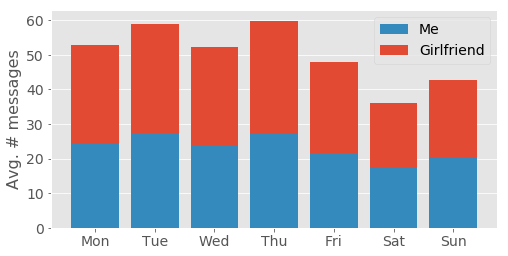

In [41]:
df_weekdays = df.groupby([df['Datetime'].dt.weekday, 'Name'])\
                .count().unstack(fill_value=0).stack()\
                .drop(['Datetime'], axis=1)\
                .apply(lambda x: x*7/days_total)\
                .rename(columns={'Message': 'Count'})
df_hours.index.names = ['Weekday', 'Name']

bars1 = df_weekdays.xs(nick1, level='Name')['Count']
bars2 = df_weekdays.xs(nick2, level='Name')['Count']

fig, ax = plt.subplots(figsize=(8,4))
plt.bar(np.arange(0,7), bars1, color='C1')
plt.bar(np.arange(0,7), bars2.values, bottom=bars1.values, color='C0')
plt.ylabel('Avg. # messages')
plt.legend([nick1, nick2])
plt.xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='x')

### Insights
- During work days the distribution is fairly uniform with slightly increased messaging on Tuesdays and Thursday.
- At the weekends, when there is more time to spend together in person, the number of messages sent is significantly lower.

## Timeline statistic
Visualizing the number of messages sent on a timeline can reveal some long-term changes in messaging behavior. Here, I'm particularly interested in how much moving in together affected the amount of messages we send to each other. 

Text(737058.0, 120, 'Moved in\ntogether')

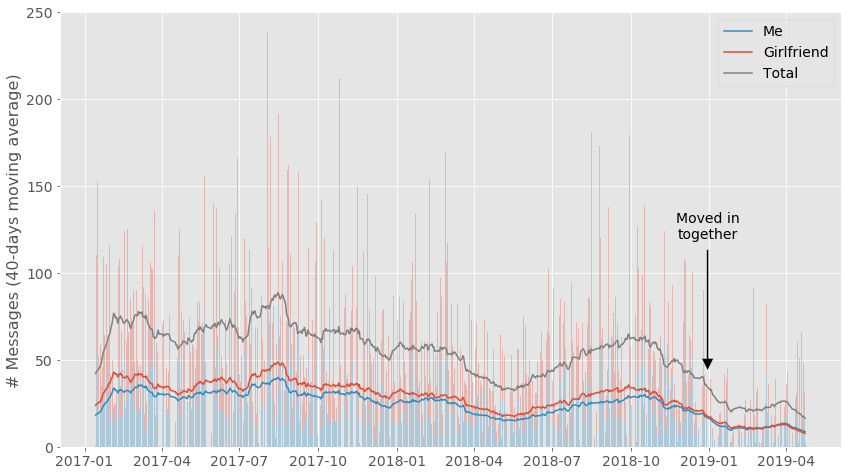

In [42]:
df_days = df.groupby([df['Datetime'].dt.date, 'Name'])\
                .count().unstack(fill_value=0).stack()\
                .drop(['Datetime'], axis=1)\
                .rename(columns={'Message': 'Count'})
df_days.index.names = ['Date', 'Name']

bars1 = df_days.xs(nick1, level='Name')['Count']
bars2 = df_days.xs(nick2, level='Name')['Count']
dates = bars1.index.get_level_values('Date')

# Calculate running averages using Numpy's convolve
N_avg = 40
run_avg1 = np.convolve(bars1, np.ones((N_avg,))/N_avg, mode='same')
run_avg2 = np.convolve(bars2, np.ones((N_avg,))/N_avg, mode='same')

plt.figure(figsize=(14,8))
plt.bar(dates, bars1.values, color='C1', alpha=0.3)
plt.bar(dates, bars2.values, bottom=bars1.values, color='C0', alpha=0.3)
plt.plot(dates, run_avg1, color='C1')
plt.plot(dates, run_avg2, color='C0')
plt.plot(dates, run_avg1 + run_avg2, color='grey')
plt.ylabel('# Messages (' + str(N_avg) + '-days moving average)')
plt.legend([nick1, nick2, 'Total'])

# Annotate some specific events on the timeline (here: move-in date)
event_date = '2018-12-30'
plt.annotate('Moved in\ntogether', (mdates.datestr2num(event_date),40),\
             (mdates.datestr2num(event_date),120),\
              arrowprops=dict(facecolor='k', width=2, shrink=0.05),
              fontsize=SMALL_SIZE, horizontalalignment='center')

### Inisghts
- The 40-day moving average, while being quite volatile, doesn't show any clear trends before the move-in date except for a possible dip in May/June 2018. Reason unknown.
- In the period after - and interestingly leading to - the move-in date the number of messages dropped considerably.
- For a meaningful analysis of the effect of the move-in more data of the period after the move-in is necessary.

## Most frequenly used words
With the message contents at hand, one can employ a word count routine to determine the most frequently used words by each person. For a meaningful word list, however, some common boring words should be excluded from the analysis.

In [43]:
boring_words = ['the', 'i', 'you', 'and', 'to', 'a', 'it', 'is', 'my', 'for', 'so', 'in', 'have', 'but', 'will', 'was', 'im',\
               'of', 'we', 'are', 'can', "i'm", 'that', 'some', 'be', 'how', 'not', 'with', "it's", 'on', 'at', 'that',\
                "that's", 'they', "i'll", 'your', 'if', 'do', 'or', 'then', 'from', "don't", 'when', 'had', 'as', 'them', 'an',\
               'he', 'she', 'its', 'me', 'this', 'did', 'her', 'did', 'him', '<media', 'omitted>']

word_list1 = df[df['Name'] == nick1]['Message'].str.split().sum()
word_list2 = df[df['Name'] == nick2]['Message'].str.split().sum()
word_list1 = [x.lower().translate({ord(c): None for c in '.,:;!?'}) for x in word_list1]
word_list2 = [x.lower().translate({ord(c): None for c in '.,:;!?'}) for x in word_list2]
word_list1 = [x for x in word_list1 if x not in boring_words]
word_list2 = [x for x in word_list2 if x not in boring_words]
count1 = collections.Counter(word_list1).most_common(50)
count2 = collections.Counter(word_list2).most_common(50)

count1 = list(zip(*count1))
count2 = list(zip(*count2))
print(count1)

[('dudiczku', 'oh', 'yes', 'good', 'ok', '😊', '😘😘😘', 'now', 'dobranoc', 'no', 'thank', 'too', 'also', 'think', 'yeees', '😃', 'there', 'nice', 'just', 'very', 'yeah', 'haha', 'tomorrow', 'maybe', 'today', 'about', '😘', 'one', 'hahaha', 'home', 'know', 'time', 'going', 'like', 'd', 'hellou', 'sure', 'uh', 'bit', 'go', 'alright', 'sorry', 'ah', 'would', 'what', 'cuteness', 'yea', 'sweetness', 'work', 'all'), (1095, 1082, 975, 951, 915, 822, 702, 656, 636, 609, 602, 574, 573, 559, 554, 539, 525, 516, 506, 499, 486, 470, 425, 418, 416, 392, 386, 364, 354, 351, 350, 344, 335, 324, 321, 317, 305, 299, 292, 288, 284, 282, 279, 276, 274, 261, 248, 245, 244, 234)]


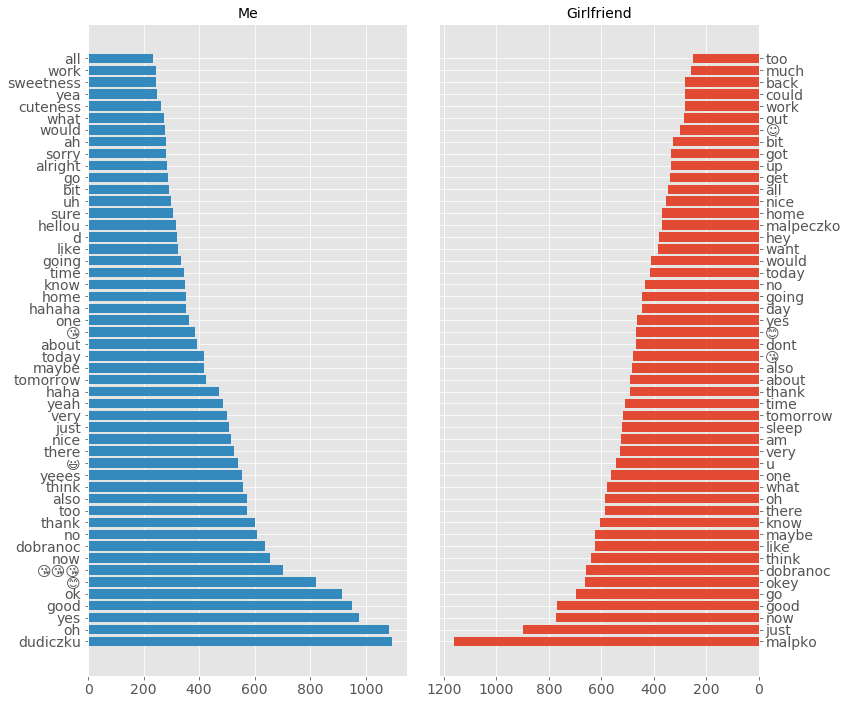

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12,10))
axs[0].barh(count1[0], count1[1], height=0.8, color='C1')
axs[0].set_title(nick1)
axs[1].barh(count2[0], count2[1], height=0.8, color='C0')
axs[1].set_title(nick2)
plt.gca().invert_xaxis()
axs[1].yaxis.tick_right()
plt.tight_layout()

### Insights
- Adorably, the most used word both, by me and my girlfriend, is each other's nickname.
- My messages seem much more emoji-heavy. :-D